In [1]:
import os

# Set your desired cache directory path
cache_directory = "/projectnb/ds598/admin/xthomas/sp2024_notebooks/discussion/tmp"

# Set the TRANSFORMERS_CACHE environment variable
os.environ["TRANSFORMERS_CACHE"] = cache_directory

import logging
from transformers import logging as transformers_logging

# Set the logging level to ERROR to reduce output (only critical errors will be shown)
transformers_logging.set_verbosity_error()

/projectnb/ds598/projects/xthomas/.conda/envs/ds598/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Bare Basics

What is Hugging Face🤗?

Transformer models are pretty large, with millions to billions of parameters. Training these models from scratch is computationally expensive and time-consuming. Hugging Face is a company that has developed a library called `transformers` that provides pre-trained transformer models and a collection of tools to work with them. Moreover, with new models being released on a near-daily basis and each having its own implementation, it can be difficult to keep up with the latest. Hugging Face provides an easy-to-use interface to access these models and use them for various tasks.

The `transformers` library was created to be a portal to the world of transformer models. It provides a simple API to access a wide range of transformer models, through which any transformer model can be loaded, trained, and saved. Main features:

- Ease of use: Downloading, loading, and using a state-of-the-art NLP model for inference can be done in just two lines of code. (Model and the Prcoessor)
- Flexibility: At their core, all models are simple PyTorch nn.Module or TensorFlow tf.keras.Model classes and can be handled like any other models in their respective machine learning (ML) frameworks.
- Simplicity: Hardly any abstractions are made across the library. The “All in one file” is a core concept: a model’s forward pass is entirely defined in a single file, so that the code itself is understandable and hackable.

## Pipeline

In [2]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis") # default model: distilbert-base-uncased-finetuned-sst-2-english
classifier(
    [
        "I've been waiting for it my whole life.",
        "I hate this so much!",
    ]
)

[{'label': 'POSITIVE', 'score': 0.9964979887008667},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

### What does pipeline do?

The `pipeline` class is a high-level way to use a model for inference. It is a simple way to perform inference on a wide range of tasks using a pre-trained model. It groups together three steps:
- Preprocessing the inputs
- Forward pass through the model
- Post-processing the model outputs

![title](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg)

### Preprocessing with a tokenizer (Recap)

Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a tokenizer, which will be responsible for:

Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
Mapping each token to an integer
Adding additional inputs that may be useful to the model

**Note:** All this preprocessing needs to be done in exactly the same way as when the model was pretrained, so we first need to download that information from the Model Hub.

To do so, we use the AutoTokenizer class and its from_pretrained() method. Using the checkpoint name of our model, it will automatically fetch the data associated with the model’s tokenizer and cache it (so it’s only downloaded the first time you run the code below).

In [3]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir = cache_directory)

Another **Note**: You can use 🤗 Transformers without having to worry about which ML framework is used as a backend; it might be PyTorch or TensorFlow, or Flax for some models. 

Although for downstream tasks, to specify the type of tensors we want to get back (PyTorch, TensorFlow, or plain NumPy), we use the return_tensors argument:

In [4]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [5]:
print(inputs['attention_mask'])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


### What is the attention mask?

The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the model to know which elements in the sequence are padding tokens and which are words, we need to provide an attention mask. It is a tensor of the same length as the input IDs tensor and contains a 1 on all the non-padded tokens and a 0 on all the padded ones.


In the above example, the largest sequence has 16 tokens, so the tokenizer pads the second sequence with zeros to make it the same length. The attention mask tensor has a 1 for each token in the input_ids tensor and a 0 for each padding token. This way, the model knows which tokens are padding and which are actual tokens.

### Why is it needed?

- Handling variable-length sequences: In practice, batches of text data often contain sentences of varying lengths. To process them efficiently in parallel, these sentences are padded to a common length, the longest sentence in the batch. The attention mask enables the model to differentiate between actual data and padding, ensuring that the padding tokens do not affect the computation.

- Preserving sequence integrity: Without an attention mask, the model would treat padding tokens as part of the input sequence, leading to skewed or incorrect results. By using the attention mask, the model can maintain the integrity of the actual sequence information, focusing only on the meaningful tokens during the training and inference processes.

- Optimizing computation: By ignoring the padding tokens, the model can reduce unnecessary computations. This optimization is especially important in large models and datasets, leading to more efficient processing and potentially faster training and prediction times.

- Improving model performance: Attention masks help maintain the context of the sequences by preventing the model from attending to padding tokens. This focus on relevant tokens often results in better model performance, as the attention mechanism can more accurately capture dependencies and relationships in the text data.




### The Model

In [6]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint, cache_dir = cache_directory)

In [7]:
outputs = model(**inputs) # unpack the dictionary, and pass it as keyword arguments
print(outputs.keys())
print(outputs.last_hidden_state.shape)

odict_keys(['last_hidden_state'])
torch.Size([2, 16, 768])


AutoModel here only loads the model architecture (no pre-trained weights). The model is responsible for the forward pass, so it’s the part that will output the hidden states of the transformer. The hidden states can then be used for whatever downstream task you have in mind.

There are many different architectures available in Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

- AutoModel (retrieve the hidden states)
- *ForCausalLM
- *ForMaskedLM
- *ForMultipleChoice
- *ForQuestionAnswering
- *ForSequenceClassification
- *ForTokenClassification
and others 

For sentiment analysis, need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the AutoModel class, but `AutoModelForSequenceClassification`:

In [8]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, cache_dir = cache_directory)
outputs = model(**inputs)
print(outputs.keys())
print(outputs.logits.shape) # 2 sentences, 2 ouputs --> [2, 2]

odict_keys(['logits'])
torch.Size([2, 2])


In [9]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


In [10]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [11]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.40.0.dev0",
  "vocab_size": 30522
}

In [12]:
id2label = model.config.id2label

# Get the indices of the max logit to get the predicted class indices
predicted_indices = torch.argmax(predictions, dim=-1)

# Map the predicted class indices to labels
predicted_labels = [id2label[idx.item()] for idx in predicted_indices]

print(raw_inputs)
print(predicted_labels)

["I've been waiting for a HuggingFace course my whole life.", 'I hate this so much!']
['POSITIVE', 'NEGATIVE']


In [13]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir = cache_directory)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, cache_dir = cache_directory)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")

# This is new
batch["labels"] = torch.tensor([1, 1])

pipeline_ = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
print(pipeline_(sequences))

optimizer = AdamW(model.parameters())
loss = model(**batch).loss
loss.backward()
optimizer.step()

pipeline_ = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
pipeline_(sequences)

[{'label': 'LABEL_1', 'score': 0.5167546272277832}, {'label': 'LABEL_1', 'score': 0.523101806640625}]


/projectnb/ds598/projects/xthomas/.conda/envs/ds598/lib/python3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[{'label': 'LABEL_1', 'score': 0.8232547640800476},
 {'label': 'LABEL_1', 'score': 0.9008342027664185}]

### Misc

In [14]:
sequence = "A sample sentence, to be tokenized."

model_inputs = tokenizer(sequence)
print(model_inputs["input_ids"])
print(len(model_inputs["input_ids"]))

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)
print(len(ids))

[101, 1037, 7099, 6251, 1010, 2000, 2022, 19204, 3550, 1012, 102]
11
[1037, 7099, 6251, 1010, 2000, 2022, 19204, 3550, 1012]
9


In [15]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

[CLS] a sample sentence, to be tokenized. [SEP]
a sample sentence, to be tokenized.


The tokenizer added the special word `[CLS]` at the beginning and the special word `[SEP]` at the end. This is because the model was pretrained with those, so to get the same results for inference we need to add them as well. Note that some models don’t add special words, or add different ones; models may also add these special words only at the beginning, or only at the end. In any case, the tokenizer knows which ones are expected and will deal with this for you.

[{'score': 0.4335, 'label': 'lynx, catamount'},
 {'score': 0.0348,
  'label': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor'},
 {'score': 0.0324, 'label': 'snow leopard, ounce, Panthera uncia'},
 {'score': 0.0239, 'label': 'Egyptian cat'},
 {'score': 0.0229, 'label': 'tiger cat'}]

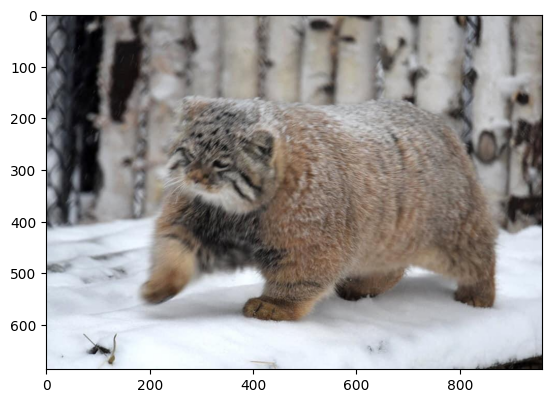

In [16]:
from transformers import pipeline

vision_classifier = pipeline(model="google/vit-base-patch16-224")
preds = vision_classifier(
    images="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
)

# plot the image
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

response = requests.get("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")
img = Image.open(BytesIO(response.content))
plt.imshow(img)

preds = [{"score": round(pred["score"], 4), "label": pred["label"]} for pred in preds]
preds

##### 1. Search for models based on task here: https://huggingface.co/models?sort=trending

<img src="https://github.com/XThomasBU/sp2024_notebooks/blob/main/discussion/disc8/imgs/img1.png?raw=true">


#### 2. Click on a Model, to see its Model Card

<img src="https://github.com/XThomasBU/sp2024_notebooks/blob/main/discussion/disc8/imgs/img2.png?raw=true">

#### 3. Most Model Cards will have details on how to use the model

<img src="https://github.com/XThomasBU/sp2024_notebooks/blob/main/discussion/disc8/imgs/img3.png?raw=true">

#### 4. See how other people have used the model

<img src="https://github.com/XThomasBU/sp2024_notebooks/blob/main/discussion/disc8/imgs/img4.png?raw=true">